<a href="https://colab.research.google.com/github/monozi/CCMACLRL_EXERCISES_COM221ML/blob/main/Exercise_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 7: Hate Speech Classification using Multinomial Naive Bayes

Instructions:
- You do not need to split your data. Use the training, validation and test sets provided below.
- Use Multinomial Naive Bayes to train a model that can classify if a sentence if a hate speech or not
- A sentence with a label of zero (0) is classified as non-hate speech
- A sentence with a label of one (1) is classified as a hate speech

Apply text pre-processing techniques such as
- Converting to lowercase
- Stop word Removal
- Removal of digits, special characters
- Stemming or Lemmatization but not both
- Count Vectorizer or TF-IDF Vectorizer but not both

Evaluate your model by:
- Providing input by yourself
- Creating a Confusion Matrix
- Calculating the Accuracy, Precision, Recall and F1-Score

In [183]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import seaborn as sns
import re
import os, types

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, accuracy_score, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download("punkt")
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [184]:
splits = {'train': 'unique_train_dataset.csv', 'validation': 'unique_validation_dataset.csv', 'test': 'unique_test_dataset.csv'}

## Training Set

Use this to train your model

In [185]:
df_train = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])

In [186]:
df_train.head()

,text,label
0,Presidential candidate Mar Roxas implies that ...,1
1,Parang may mali na sumunod ang patalastas ng N...,1
2,Bet ko. Pula Ang Kulay Ng Posas,1
3,[USERNAME] kakampink,0
4,Bakit parang tahimik ang mga PINK about Doc Wi...,1


In [187]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21773 entries, 0 to 21772
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    21773 non-null  object
 1   label   21773 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 340.3+ KB


<ipython-input-188-7de7569ace88>:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count =pd.value_counts(df_train["label"], sort= True)


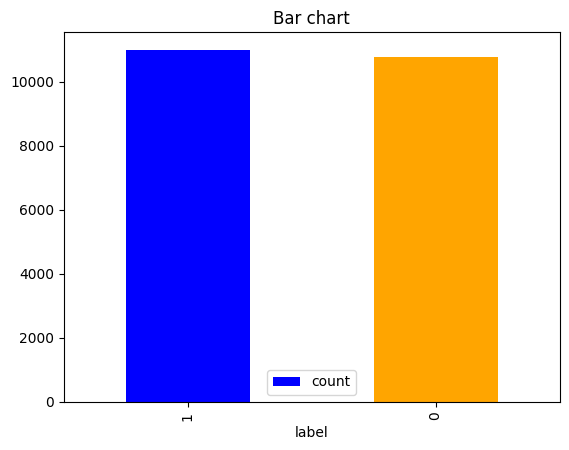

In [188]:
import matplotlib.pyplot as plt
count =pd.value_counts(df_train["label"], sort= True)
count.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Bar chart')
plt.legend(loc='best')
plt.show()

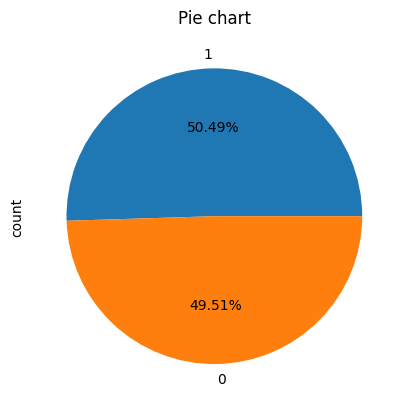

In [189]:
count.plot(kind = 'pie',autopct='%1.2f%%') # 1.2 is the decimal points for 2 places
plt.title('Pie chart')
plt.show()

In [190]:
tagalog = ["akin","aking","ako","alin","am","amin","aming","ang","ano","anumang","apat","at","atin","ating","ay","bababa","bago","bakit","bawat",
           "bilang","dahil","dalawa","dapat","din","dito","doon","gagawin","gayunman","ginagawa","ginawa","ginawang","gumawa","gusto","habang",
           "hanggang","hindi","huwag","iba","ibaba","ibabaw","ibig","ikaw","ilagay","ilalim","ilan","inyong","isa","isang","itaas","ito","iyo",
           "iyon","iyong","ka","kahit","kailangan","kailanman","kami","kanila","kanilang","kanino","kanya","kanyang","kapag","kapwa","karamihan",
           "katiyakan","katulad","kaya","kaysa","ko","kong","kulang","kumuha","kung","laban","lahat","lamang","likod","lima","maaari","maaaring",
           "maging","mahusay","makita","marami","marapat","masyado","may","mayroon","mga","minsan","mismo","mula","muli","na","nabanggit","naging",
           "nagkaroon","nais","nakita","namin","napaka","narito","nasaan","ng","ngayon","ni","nila","nilang","nito","niya","niyang","noon","o","pa",
           "paano","pababa","paggawa","pagitan","pagkakaroon","pagkatapos","palabas","pamamagitan","panahon","pangalawa","para","paraan","pareho",
           "pataas","pero","pumunta","pumupunta","sa","saan","sabi","sabihin","sarili","sila","sino","siya","tatlo","tayo","tulad","tungkol","una","walang"]

In [191]:
# converting text to lowercase
df_train["text"] = df_train["text"].str.lower()

# Removing stopwords from the data
stop_words = tagalog + stopwords.words("english")
df_train["text"] = df_train["text"].apply(lambda x: " ".join(word for word in x.split() if word not in stop_words))

# removing links
df_train["text"] = df_train["text"].apply(lambda x: re.sub(r"http\S+|www\.\S+", "", x))

# removing email addresses
df_train["text"] = df_train["text"].apply(lambda x: re.sub(r"\w+@\w+\.com", "", x))

# removing punctuation marks
df_train["text"] = df_train["text"].apply(lambda x: re.sub(r"[.,;:!\?\"'`]", "", x))

# removing special characters
df_train["text"] = df_train["text"].apply(lambda x: re.sub(r"[@#$%^&*\/\+-_=\{\}<>]", "", x))

# removing unnecessary characters
df_train["text"] = df_train["text"].apply(lambda x: re.sub(r"½m|½s|½t|½ï", "", x))

df_train.head()

,text,label
0,presidential candidate mar roxas implies govt ...,1
1,parang mali sumunod patalastas nescaf coffee b...,1
2,bet ko pula kulay posas,1
3,username kakampink,0
4,parang tahimik pink doc willie ong reaction paper,1


In [192]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21773 entries, 0 to 21772
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    21773 non-null  object
 1   label   21773 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 340.3+ KB


In [193]:
# applying lemmatization
wnl = WordNetLemmatizer()
df_train["text"] = df_train["text"].apply(lambda x: " ".join(wnl.lemmatize(word, "v") for word in x.split()))

In [194]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21773 entries, 0 to 21772
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    21773 non-null  object
 1   label   21773 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 340.3+ KB


## Test Set

Use this set to test your model

In [195]:
df_test = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["test"])

In [196]:
X_train = df_train["text"].values
Y_train = df_train["label"].values

X_test = df_test["text"].values
Y_test  = df_test["label"].values

In [197]:
def transform_model_data_w_tfidf_vectorizer(preprocessed_text, Y_train,  X_test, Y_test):
    #vectorize dataset
    tfidf = TfidfVectorizer()
    vectorized_data = tfidf.fit_transform(preprocessed_text)

    #define model
    model = MultinomialNB(alpha=0.1)
    model.fit(vectorized_data, Y_train)

    #evaluate model
    predictions = model.predict(tfidf.transform(X_test))

    accuracy = accuracy_score( Y_test, predictions)
    balanced_accuracy = balanced_accuracy_score(Y_test, predictions)
    precision = precision_score(Y_test, predictions)

    print("Accuracy:",round(100*accuracy,2),'%')
    print("Balanced accuracy:",round(100*balanced_accuracy,2),'%')
    print("Precision:", round(100*precision,2),'%')
    return predictions, model, tfidf

In [198]:
predictions, model, vectorizer = transform_model_data_w_tfidf_vectorizer(X_train, Y_train,  X_test, Y_test)

Accuracy: 80.89 %
Balanced accuracy: 80.93 %
Precision: 76.72 %


## Validation Set

Use this set to evaluate your model

In [199]:
df_validation = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["validation"])

In [201]:
X_val = df_validation["text"].values
Y_val  = df_validation["label"].values

predictions, model, vectorizer = transform_model_data_w_tfidf_vectorizer(X_train, Y_train,  X_val, Y_val)

Accuracy: 80.75 %
Balanced accuracy: 80.67 %
Precision: 77.24 %


In [202]:
new_text = pd.Series("gago")

new_text_transform = vectorizer.transform(new_text)
prediction = model.predict(new_text_transform)
if prediction == 1:
    print("hate speech")
else:
    print("non-hate speech")

hate speech
